In [1]:
import matplotlib.pyplot as plt
import bioframe 
import pandas as pd
import numpy as np 
import os
import json
from io import StringIO

import akita_utils 
import pysam
import h5py
genome_open = pysam.Fastafile('/project/fudenber_735/genomes/mm10/mm10.fa')

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '-1'
import tensorflow as tf
print(tf.__version__)

import pysam
from basenji import dataset, seqnn, dna_io,stream
head_i = 1 #mouse
model_num = 1 #which fold to use

base_dir = '/project/fudenber_735/tensorflow_models/akita/v2/models/'
model_dir = base_dir+"/f"+str(model_num)+"c0/train/"
model_file  = model_dir+'/model'+str(head_i)+'_best.h5'

params_file = model_dir+'/params.json'
with open(params_file) as params_open:
    params = json.load(params_open)
    params_model = params['model']
    params_train = params['train']
seq_length = params_model['seq_length']
params_model['verbose'] = False
seqnn_model = seqnn.SeqNN(params_model)
print('built')
seqnn_model.restore(model_file, head_i=head_i)
print('restored')

hic_diags = params_model['diagonal_offset']
try:
    target_crop = params_model['trunk'][-2]['cropping']
except:
    target_crop = params_model['target_crop']
target_length_cropped = int((seq_length//2048 - target_crop*2 - hic_diags)* ((seq_length//2048 - target_crop*2 - hic_diags) +1)/2) 
target_map_size = seq_length//2048  - target_crop*2 
triu_tup = np.triu_indices(target_map_size,2)
target_map_size, target_length_cropped, triu_tup[0].shape

2.4.1


2022-06-17 19:02:19.802426: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence (InputLayer)           [(None, 1310720, 4)] 0                                            
__________________________________________________________________________________________________
stochastic_reverse_complement ( ((None, 1310720, 4), 0           sequence[0][0]                   
__________________________________________________________________________________________________
stochastic_shift (StochasticShi (None, 1310720, 4)   0           stochastic_reverse_complement[0][
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 1310720, 4)   0           stochastic_shift[0][0]           
____________________________________________________________________________________________

(512, 130305, (130305,))

# creating motifs dataframe

In [3]:
site_df = akita_utils.prepare_insertion_tsv(
    h5_dirs = '/project/fudenber_735/tensorflow_models/akita/v2/analysis/permute_boundaries_motifs_ctcf_mm10_model*/scd.h5',
    score_key = 'SCD',
    flank_pad = 60, #how much flanking sequence around the sites to include
    weak_thresh_pct = 1, # don't use sites weaker than this, might be artifacts
    weak_num = 5 ,
    strong_thresh_pct = 99, # don't use sites weaker than this, might be artifacts
    strong_num = 5 ,
    save_tsv = None, # optional filename to save a tsv
)
# num_seqs = site_df.shape[0]

29 duplicates removed for  /project/fudenber_735/tensorflow_models/akita/v2/analysis/permute_boundaries_motifs_ctcf_mm10_model7/scd.h5
29 duplicates removed for  /project/fudenber_735/tensorflow_models/akita/v2/analysis/permute_boundaries_motifs_ctcf_mm10_model1/scd.h5
annotating each site with boundary-wide scores
filtering sites by overlap with rmsk
df prepared


In [4]:
site_df#['end']- site_df['start']

,index,chrom,start,end,strand,genomic_SCD
0,0,chr12,35192299,35192438,-,53.656250
1,1,chr8,102781052,102781191,-,53.500000
2,2,chr5,49961931,49962070,-,53.312500
3,3,chr9,26776296,26776435,-,53.125000
4,4,chr9,51152529,51152668,-,53.062500
5,0,chr7,139598251,139598390,+,0.058136
6,1,chr8,45342859,45342998,+,0.058319
7,2,chr2,27771606,27771745,-,0.058746
8,3,chr1,35713828,35713967,+,0.059021
9,4,chr9,51333550,51333689,-,0.059021


# creating flat maps 

In [5]:

genome_fasta = '/project/fudenber_735/genomes/mm10/mm10.fa'

flat_seqs = akita_utils.create_flat_seqs(seqnn_model=seqnn_model, 
                                         genome_fasta=genome_fasta, 
                                         site_df=site_df, 
                                         seq_length=seq_length,  
                                         max_iters = 5, 
                                         batch_size = 6, 
                                         shuffle_k = 8, 
                                         ctcf_thresh = 8, 
                                         scores_thresh = 5500, 
                                         scores_pixelwise_thresh = .04 )


0
ind 0 , iter  0 , for chr12 34537008 35847728
0


2022-06-17 19:02:42.081356: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-06-17 19:02:42.082020: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2599950000 Hz


success: best seq, thresh 5010.0  pixelwise 0.03513
max iters exceeded
1
ind 1 , iter  0 , for chr8 102125761 103436481
1
trying: best seq, thresh 5204.0  pixelwise 0.04004
ind 1 , iter  1 , for chr8 102125761 103436481
1
success: best seq, thresh 5310.0  pixelwise 0.038
max iters exceeded
2
ind 2 , iter  0 , for chr5 49306640 50617360
2
success: best seq, thresh 5176.0  pixelwise 0.03815
max iters exceeded
3
ind 3 , iter  0 , for chr9 26121005 27431725
3
success: best seq, thresh 5440.0  pixelwise 0.03644
max iters exceeded
4
ind 4 , iter  0 , for chr9 50497238 51807958
4
trying: best seq, thresh 6384.0  pixelwise 0.04047
ind 4 , iter  1 , for chr9 50497238 51807958
4
success: best seq, thresh 4880.0  pixelwise 0.0364
max iters exceeded
5
ind 5 , iter  0 , for chr7 138942960 140253680
5
trying: best seq, thresh 26830.0  pixelwise 0.1877
ind 5 , iter  1 , for chr7 138942960 140253680
5
trying: best seq, thresh 25490.0  pixelwise 0.175
ind 5 , iter  2 , for chr7 138942960 140253680
5
tr

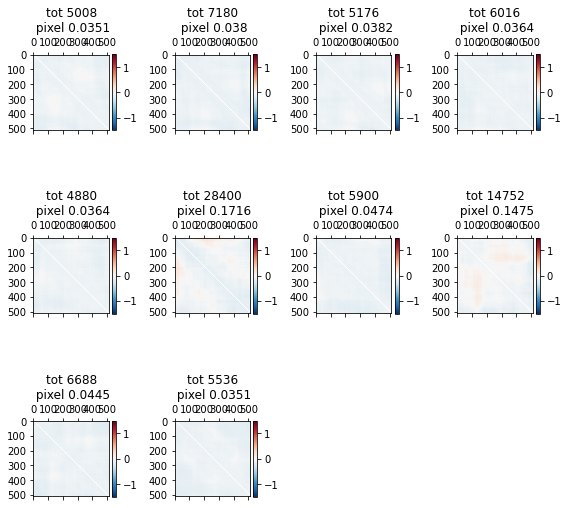

In [7]:
num_panels = batch_size = 6
#plt.figure(figsize=(5*2,2*num_panels))
plt.figure(figsize=(8,8))#,6))

target_ind = 0
vlim = 1.5

for i in range(len(flat_seqs)):
    flat_pred = flat_seqs[i][1]
    
    plt.subplot(3,4, i+1)
    im = plt.matshow(
            akita_utils.from_upper_triu(  flat_pred[:,target_ind], target_map_size,hic_diags),
             vmin=-1*vlim,vmax=vlim, fignum=False,cmap='RdBu_r')
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.title('tot '+
            str(np.round(flat_seqs[i][2],0).astype(int))+'\n pixel '+
            str(np.round(flat_seqs[i][3],4)) ) 
        
plt.tight_layout()
plt.show()

In [8]:
with open('backround_seqs.fa','w') as f:
    for i in range(len(flat_seqs)):
        f.write('>seq'+str(i)+'_score'+str(int(flat_seqs[i][2]))+'_pixelwise'+str(int(flat_seqs[i][3]*1000))+'\n')
        f.write(dna_io.hot1_dna(flat_seqs[i][0])+'\n')
       